In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import matplotlib.colors as mcolors

import os
import glob
from contextlib import contextmanager
import rasterio
import numpy as np
@contextmanager
def cwd(path: str) -> None:
    
    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """
    
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
diretorio = 'D:/CloudSEN12+/p509/Imagens-Amazonia/'
with cwd(diretorio):
        imagens = sorted(os.listdir())

def normalize_band(band):
        #band = (band + 1000) / 10000
        #band = band.clip(min=0)
        
        return ((band - band.min()) / (band.max() - band.min()))

(15, 509, 509)


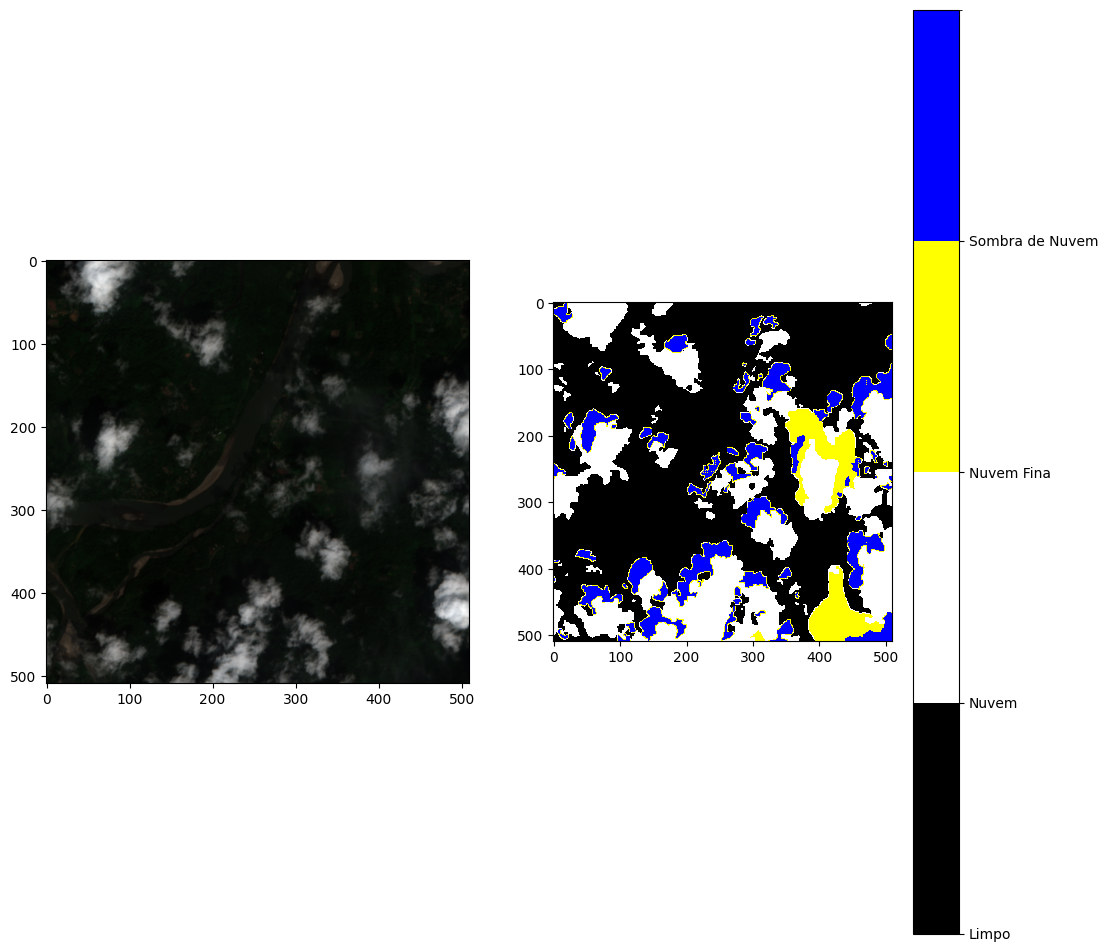

In [10]:

src = rasterio.open(diretorio+imagens[4])
# Ler todas as bandas
bandas = src.read()

# Verificar o número de bandas
print(bandas.shape)  # (n_bandas, altura, largura)
b_r = normalize_band(bandas[3])
b_g = normalize_band(bandas[2])
b_b = normalize_band(bandas[1])

cmap = mcolors.ListedColormap(['black', 'white', 'yellow', 'blue'])  # Defina as cores
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


rgb_composite_raw = np.dstack((b_r, b_g, b_b))

plt.figure(figsize=(12, 12))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_raw)

plt.subplot(1,2,2)
plt.imshow(bandas[13], cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Limpo', 'Nuvem', 'Nuvem Fina', 'Sombra de Nuvem'])
plt.show()


(15, 2000, 2000)


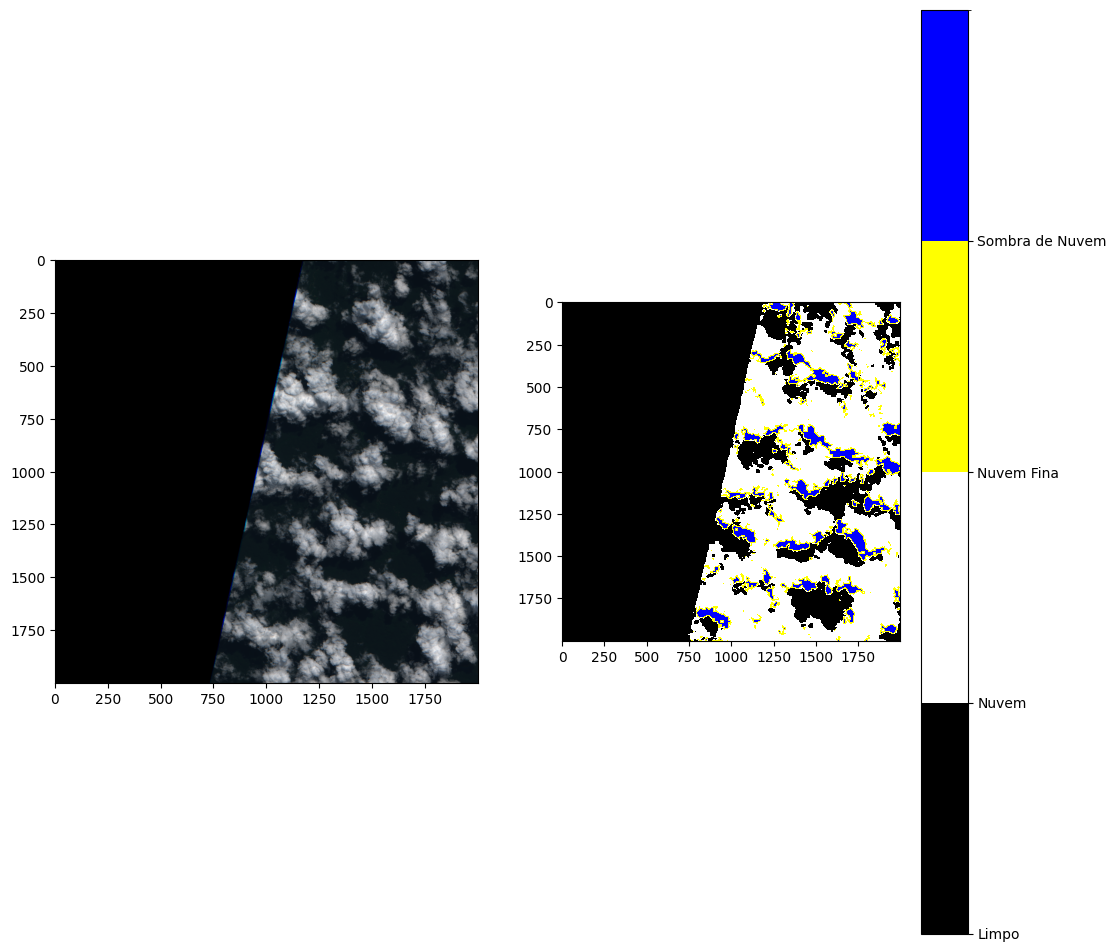

'\n# 2. Obter a localização do Tile ID usando sentinelhub-py\ntile_id = UtmTile(19, \'N\', \'BH\')  # ID do Tile: T19FDF\nbbox = tile_id.get_bbox(crs=CRS.WGS84)  # Caixa delimitadora em coordenadas WGS84 (latitude e longitude)\n\n# Obter coordenadas do centro da imagem\nlongitude_center = (bbox.lower_left[0] + bbox.upper_right[0]) / 2\nlatitude_center = (bbox.lower_left[1] + bbox.upper_right[1]) / 2\n\nprint(f"Localização central do Tile: Latitude {latitude_center}, Longitude {longitude_center}")\n\n# 3. Plotar o mapa do mundo e marcar a localização da imagem\n# Carregar o shapefile com os limites dos países\nworld = gpd.read_file(gpd.datasets.get_path(\'naturalearth_lowres\'))\n\n# Criar a plotagem\nfig, ax = plt.subplots(figsize=(12, 8))\nworld.plot(ax=ax, color=\'lightgray\')  # Plotar o mapa do mundo\n\n# Adicionar o ponto correspondente à localização da imagem\nplt.scatter(longitude_center, latitude_center, color=\'red\', marker=\'x\', s=100, label=\'Sentinel-2 Image Location\')\n

In [5]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelhub import BBox, CRS
import matplotlib.colors as mcolors
import numpy as np

def normalize_band(band):
        #band = (band + 1000) / 10000
        #band = band.clip(min=0)
        
        return ((band - band.min()) / (band.max() - band.min()))

# 1. Abrir a imagem .tif usando rasterio
file_path = "D:/CloudSEN12+/p2000/high/Imagens-Amazonia/20210618T141051_20210618T141046_T21NWB__ROI_3183.tif"

with rasterio.open(file_path) as src:
    # Ler a primeira banda (ou qualquer banda específica)
    img = src.read()
    
    bandas = src.read()
    # Verificar o número de bandas
    print(bandas.shape)  # (n_bandas, altura, largura)
    b_r = normalize_band(bandas[3])
    b_g = normalize_band(bandas[2])
    b_b = normalize_band(bandas[1])

    cmap = mcolors.ListedColormap(['black', 'white', 'yellow', 'blue'])  # Defina as cores
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    rgb_composite_raw = np.dstack((b_r, b_g, b_b))
    plt.figure(figsize=(12, 12))
    plt.subplot(1,2,1)
    plt.imshow(rgb_composite_raw)
    plt.subplot(1,2,2)
    plt.imshow(bandas[13], cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2, 3])
    cbar.set_ticklabels(['Limpo', 'Nuvem', 'Nuvem Fina', 'Sombra de Nuvem'])
    plt.show()
'''
# 2. Obter a localização do Tile ID usando sentinelhub-py
tile_id = UtmTile(19, 'N', 'BH')  # ID do Tile: T19FDF
bbox = tile_id.get_bbox(crs=CRS.WGS84)  # Caixa delimitadora em coordenadas WGS84 (latitude e longitude)

# Obter coordenadas do centro da imagem
longitude_center = (bbox.lower_left[0] + bbox.upper_right[0]) / 2
latitude_center = (bbox.lower_left[1] + bbox.upper_right[1]) / 2

print(f"Localização central do Tile: Latitude {latitude_center}, Longitude {longitude_center}")

# 3. Plotar o mapa do mundo e marcar a localização da imagem
# Carregar o shapefile com os limites dos países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Criar a plotagem
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')  # Plotar o mapa do mundo

# Adicionar o ponto correspondente à localização da imagem
plt.scatter(longitude_center, latitude_center, color='red', marker='x', s=100, label='Sentinel-2 Image Location')

# Configurações do gráfico
plt.title('Localização da Imagem Sentinel-2 no Mapa Mundial')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)

# Mostrar o mapa
plt.show()
'''

In [14]:
from rasterio.transform import xy

In [15]:
lon, lat = xy(src.transform, 100, 100)
print(f'Pixel ({100}, {100}) - Longitude: {lon}, Latitude: {lat}')

Pixel (100, 100) - Longitude: 527605.0, Latitude: 156775.0


In [30]:
src.bounds

BoundingBox(left=526600.0, bottom=137780.0, right=546600.0, top=157780.0)

Pixel (2000, 2000) - Longitude: 546605.0, Latitude: 137775.0
Bounds da imagem - Esquerda: 526600.0, Direita: 546600.0, Baixo: 137780.0, Topo: 157780.0


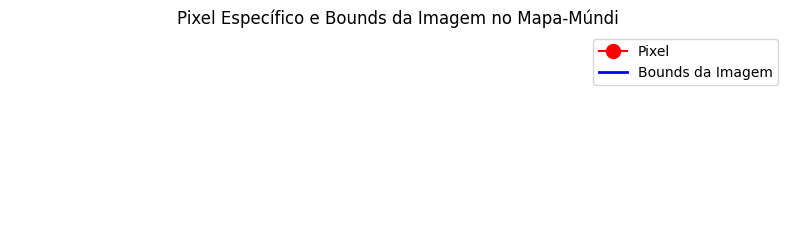

In [29]:
import rasterio
from rasterio.transform import xy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Definir o pixel que deseja analisar (linha e coluna)
row = 2000
col = 2000

# Abrir o arquivo GeoTIFF (.tif)
with rasterio.open("D:/CloudSEN12+/p2000/high/Imagens-Amazonia/20210618T141051_20210618T141046_T21NWB__ROI_3183.tif") as dataset:
    # Obter as coordenadas geográficas do pixel específico
    lon, lat = xy(dataset.transform, row, col)
    print(f'Pixel ({row}, {col}) - Longitude: {lon}, Latitude: {lat}')
    
    # Obter os limites da imagem (bounding box)
    bounds = dataset.bounds
    print(f'Bounds da imagem - Esquerda: {bounds.left}, Direita: {bounds.right}, Baixo: {bounds.bottom}, Topo: {bounds.top}')

# Configurar o plot no mapa-múndi usando Cartopy
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adicionar recursos ao mapa
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Definir o "extente" (limite visual) para centralizar a área da imagem
#ax.set_extent([bounds.left , bounds.right , bounds.bottom , bounds.top ], crs=ccrs.PlateCarree())

# Plotar o pixel específico
ax.plot(lon, lat, marker='o', color='red', markersize=10, label='Pixel')

# Plotar os limites da imagem
ax.plot([bounds.left, bounds.right, bounds.right, bounds.left, bounds.left],
        [bounds.bottom, bounds.bottom, bounds.top, bounds.top, bounds.bottom],
        color='blue', linewidth=2, label='Bounds da Imagem')

# Adicionar título e legenda
plt.title('Pixel Específico e Bounds da Imagem no Mapa-Múndi')
plt.legend()

# Exibir o mapa
plt.show()
